In [105]:
import folium
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import json
import googlemaps
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
import matplotlib.pyplot as plt
%matplotlib inline
import platform
import seaborn as sns
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family = 'AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system. sorry~~~')

import pandas_datareader.data as web
from fbprophet import Prophet
from datetime import datetime
from pandas_datareader import data
from konlpy.tag import Kkma
from konlpy.tag import Hannanum

# 많은 문장 혹은 문서 중, 유사한 문장을 찾아내는 법,
## 어떤 문장을 벡터로 표현할 수 있다면, 벡터 간 거리를 구하는 방법으로 손쉽게 해결

In [106]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df = 1)

# scikti_learn 에서 텍스트이 특징을 추츌하는 모듈에서, CountVectorizer 함수사용
### 우선 단어 자체로 feature잡기

In [107]:
contents = ['메리랑 놀러가고 싶지만 바쁜데 어떻하죠?',
           '메리는 공원에서 산책하고 노는 것을 싫어해요',
           '메리는 공원에서 노는 것도 싫어해요. 이상해요',
           '먼 곳으로 여행을 떠나고 싶은데 너무 바빠서 그러질 못하고 있어요']

In [108]:
X = vectorizer.fit_transform(contents)
vectorizer.get_feature_names()

['것도',
 '것을',
 '곳으로',
 '공원에서',
 '그러질',
 '너무',
 '노는',
 '놀러가고',
 '떠나고',
 '메리는',
 '메리랑',
 '못하고',
 '바빠서',
 '바쁜데',
 '산책하고',
 '싫어해요',
 '싶은데',
 '싶지만',
 '어떻하죠',
 '여행을',
 '이상해요',
 '있어요']

In [109]:
num_samples, num_features = X.shape
num_samples,num_features
#4개의 문장, 22개의 단어로 구성됨

(4, 22)

In [110]:
X.toarray().transpose()
#벡터화된 X의 어레이 구성도 

array([[0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 1, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 1]], dtype=int64)

## 새로운 문장을 생성해, 기존 content의 문장중 벡터상 거리가 가장 가까운 문장 출력

In [132]:
new_post = ['메리랑 공원에서 산책하고 놀고 싶어요']
new_post_vec = vectorizer.transform(new_post)
new_post_vec.toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int64)

In [133]:
#norm : 벡터의 길이, 혹은 크기를 측정하는 함수
import scipy as sp
def dist_raw(v1, v2):
    delta = v1-v2
    return sp.linalg.norm(delta.toarray())

In [134]:
best_doc =None
best_dist = 65535
best_i = None

#'메리랑 공원에서 산책하고 놀고 싶어요' 와 본 contents 간의 문장간의 벡터의 거리를 측정해준다.
for i in range(0, num_samples):
    #num_samples -> contents의문장의 갯수
    post_vec = X.getrow(i)
    d = dist_raw(post_vec, new_post_vec)
    print('==post %d with dist =%.2f : %s'%(i, d, contents[i]))
    
    if d < best_dist:
        best_dist = d
        best_i = i
        
print('Best post is %i, dist = %.2f '%(best_i, best_dist))
print('-->', new_post)
print('--->', contents[best_i])

==post 0 with dist =2.45 : 메리랑 놀러가고 싶지만 바쁜데 어떻하죠?
==post 1 with dist =2.45 : 메리는 공원에서 산책하고 노는 것을 싫어해요
==post 2 with dist =2.24 : 메리는 공원에서 노는 것도 싫어해요. 이상해요
==post 3 with dist =3.00 : 먼 곳으로 여행을 떠나고 싶은데 너무 바빠서 그러질 못하고 있어요
Best post is 2, dist = 2.24 
--> ['메리랑 공원에서 산책하고 놀고 싶어요']
---> 메리는 공원에서 노는 것도 싫어해요. 이상해요


In [114]:
for i in range(0,len(contents)):
    print(X.getrow(i).toarray())
print('--------------------')
print(new_post_vec.toarray())
#어레이의 구성도 비교 결과, newpost의 문장은 contents 중 두번째 문장과 벡터화 어레이 구성도가 가장 비슷해 보인다. 

[[0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 1 0 0 0]]
[[0 1 0 1 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0]]
[[1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0]]
[[0 0 1 0 1 1 0 0 1 0 0 1 1 0 0 0 1 0 0 1 0 1]]
--------------------
[[0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0]]


## 메리는, 메리랑 이 분리되기 때문에, 한글 문장에 대한 합리적 벡터화가 필요

In [154]:
from konlpy.tag import Twitter
t = Twitter()

C:\Users\A\Anaconda3\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [155]:
contents_token = [t.morphs(row) for row in contents]
contents_token
# 토크나이저를 통해 형태소 분석

[['메리', '랑', '놀러', '가고', '싶지만', '바쁜데', '어떻하죠', '?'],
 ['메리', '는', '공원', '에서', '산책', '하고', '노', '는', '것', '을', '싫어해요'],
 ['메리', '는', '공원', '에서', '노', '는', '것', '도', '싫어해요', '.', '이상해요'],
 ['먼',
  '곳',
  '으로',
  '여행',
  '을',
  '떠나고',
  '싶은데',
  '너무',
  '바빠서',
  '그러질',
  '못',
  '하고',
  '있어요']]

## 형태소 를 분석하고, 이것 자체를 하나의 문장으로 만들어 벡터화 함수에 쓰기 편하게 편집
### - 기존 contents 문장 형태소 분석 및 벡터라이즈

In [168]:
contents_for_vectorize = []

for content in contents_token:
    sentence = ''
    for word in content:
        sentence = sentence+ ' '+word
    contents_for_vectorize.append(sentence)
    
contents_for_vectorize

[' 메리 랑 놀러 가고 싶지만 바쁜데 어떻하죠 ?',
 ' 메리 는 공원 에서 산책 하고 노 는 것 을 싫어해요',
 ' 메리 는 공원 에서 노 는 것 도 싫어해요 . 이상해요',
 ' 먼 곳 으로 여행 을 떠나고 싶은데 너무 바빠서 그러질 못 하고 있어요']

In [175]:
X1 = vectorizer.fit_transform(contents_for_vectorize)
num_samples, num_features = X1.shape
num_samples, num_features
#벡터라이즈 한 결과, 문장은 4개이고 단어는 총 20 개로 파악이 된다. 

(4, 20)

In [170]:
vectorizer.get_feature_names()

['가고',
 '공원',
 '그러질',
 '너무',
 '놀러',
 '떠나고',
 '메리',
 '바빠서',
 '바쁜데',
 '산책',
 '싫어해요',
 '싶은데',
 '싶지만',
 '어떻하죠',
 '에서',
 '여행',
 '으로',
 '이상해요',
 '있어요',
 '하고']

In [171]:
X1.toarray().transpose()

array([[1, 0, 0, 0],
       [0, 1, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 1, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 1]], dtype=int64)

### - 거리 계산할 new_post 형태소 분석 후 벡터라이즈

In [183]:
new_post = ['메리랑 공원에서 산책하고 놀고 싶어요']

def post_token(new_post):
    new_post_tokens = [t.morphs(row) for  row in new_post]
    new_post_for_vectorize = []

    for content in new_post_tokens:
        sentence = ''
        for word in content:
            sentence = sentence+ ' '+word
        new_post_for_vectorize.append(sentence)
    return new_post_for_vectorize
    
new_post_for_vectorize = post_token(new_post)
new_post_for_vectorize

[' 메리 랑 공원 에서 산책 하고 놀고 싶어요']

In [184]:
new_post_vec = vectorizer.transform(new_post_for_vectorize)
new_post_vec.toarray()

array([[0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]],
      dtype=int64)

## 각 벡터 간의 norm 을 나눠준 후, 거리를 구하는 함수

In [172]:
#norm : 벡터의 길이, 혹은 크기를 측정하는 함수
import scipy as sp
def dist_norm(v1, v2):
    v1_normalized = v1 / sp.linalg.norm(v1.toarray())
    v2_normalized = v2 / sp.linalg.norm(v2.toarray())
    
    delta = v1_normalized - v2_normalized
    
    return sp.linalg.norm(delta.toarray())

In [173]:
best_doc =None
best_dist = 65535
best_i = None

#'메리랑 공원에서 산책하고 놀고 싶어요' 와 본 contents 간의 문장간의 벡터의 거리를 측정해준다.
for i in range(0, num_samples):
    #num_samples -> contents의문장의 갯수
    post_vec = X1.getrow(i)
    d = dist_norm(post_vec, new_post_vec)
    print('==post %d with dist =%.2f : %s'%(i, d, contents[i]))
    
    if d < best_dist:
        best_dist = d
        best_i = i
        
print('Best post is %i, dist = %.2f '%(best_i, best_dist))
print('-->', new_post)
print('--->', contents[best_i])

==post 0 with dist =1.28 : 메리랑 놀러가고 싶지만 바쁜데 어떻하죠?
==post 1 with dist =0.42 : 메리는 공원에서 산책하고 노는 것을 싫어해요
==post 2 with dist =0.89 : 메리는 공원에서 노는 것도 싫어해요. 이상해요
==post 3 with dist =1.30 : 먼 곳으로 여행을 떠나고 싶은데 너무 바빠서 그러질 못하고 있어요
Best post is 1, dist = 0.42 
--> ['메리랑 공원에서 산책하고 놀고 싶어요']
---> 메리는 공원에서 산책하고 노는 것을 싫어해요


### - 거리에 대한 계산 결과는 달라졌지만, 가장 거리상 가까운 문장을 찾는 것에 대한 결과는 크게 다르지 않다.

In [174]:
for i in range(0,len(contents)):
    print(X.getrow(i).toarray())
print('--------------------')
print(new_post_vec.toarray())

[[1 0 0 0 1 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0]]
[[0 1 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 1]]
[[0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0]]
[[0 0 1 1 0 1 0 1 0 0 0 1 0 0 0 1 1 0 1 1]]
--------------------
[[0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1]]


# 문장을 숫자로! 단어별로 가중치 부과!
## - tf -> 어떤 단어가 문서 내에서 자주 등장할 수록 중요도가 높다고 판단
## - idf -> 비교하는 모든 문서에 만약 같은 단어가 있다면, 핵심어휘일진 모르나 문서간 비교시 중요하게 판단되는 단어가 아니란 뜻으로 판단

In [180]:
def tfidf(t,d,D):
    tf = float(d.count(t)) / sum(d.count(w) for w in set(d))
    idf = sp.log( float(len(D))/(len([doc for doc in D if t in doc])))
    return tf, idf

In [187]:
a, abb, abc = ['a'], ['a','b','b'],['a','b','c']
D = [a,abb,abc]
print(tfidf('a', a, D))
print(tfidf('b', abb, D))
print(tfidf('a', abc, D))
print(tfidf('b', abc, D))
print(tfidf('c', abc, D))
#모든 문장에 특정단어 a가 있기 때문에 a에 대한 가중치 tf는 1, idf는 0, 이 두값을 곱해서 벨류로 사용한다.

(1.0, 0.0)
(0.6666666666666666, 0.4054651081081644)
(0.3333333333333333, 0.0)
(0.3333333333333333, 0.4054651081081644)
(0.3333333333333333, 1.0986122886681098)


## scikit_learn의 TfidfVectorizer를 import 해서 사용하면 tfidf 값을 계산해준다.
### 벡터화 시, tfidf 값을 계산하여 array를 구성하게 됨!

In [189]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df = 1, decode_error = 'ignore')

## - 동일한 contents 사용!

In [205]:
contents_for_vectorize = []
contents_token = [t.morphs(row) for row in contents]
for content in contents_token:
    sentence = ''
    for word in content:
        sentence = sentence+ ' '+word
    contents_for_vectorize.append(sentence)
    
X = vectorizer.fit_transform(contents_for_vectorize)
num_samples, num_features = X.shape
num_samples, num_features

(4, 20)

In [191]:
vectorizer.get_feature_names()

['가고',
 '공원',
 '그러질',
 '너무',
 '놀러',
 '떠나고',
 '메리',
 '바빠서',
 '바쁜데',
 '산책',
 '싫어해요',
 '싶은데',
 '싶지만',
 '어떻하죠',
 '에서',
 '여행',
 '으로',
 '이상해요',
 '있어요',
 '하고']

In [203]:
new_post = ['근처 공원에 메리랑 놀러가고 싶네요']
new_post_for_vectorize= post_token(new_post)
new_post_for_vectorize
#형태소 분석후, 리스트화하여

new_post_vec = vectorizer.transform(new_post_for_vectorize)
#벡터라이즈로 트랜스포밍 한다
new_post_vec.toarray()

array([[0.57457953, 0.4530051 , 0.        , 0.        , 0.57457953,
        0.        , 0.36674667, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]])

In [202]:
best_doc =None
best_dist = 65535
best_i = None

#'메리랑 공원에서 산책하고 놀고 싶어요' 와 본 contents 간의 문장간의 벡터의 거리를 측정해준다.
for i in range(0, num_samples):
    #num_samples -> contents의문장의 갯수
    post_vec = X.getrow(i)
    d = dist_norm(post_vec, new_post_vec)
    print('==post %d with dist =%.2f : %s'%(i, d, contents[i]))
    
    if d < best_dist:
        best_dist = d
        best_i = i
        
print('Best post is %i, dist = %.2f '%(best_i, best_dist))
print('-->', new_post)
print('--->', contents[best_i])

==post 0 with dist =0.90 : 메리랑 놀러가고 싶지만 바쁜데 어떻하죠?
==post 1 with dist =1.18 : 메리는 공원에서 산책하고 노는 것을 싫어해요
==post 2 with dist =1.16 : 메리는 공원에서 노는 것도 싫어해요. 이상해요
==post 3 with dist =1.41 : 먼 곳으로 여행을 떠나고 싶은데 너무 바빠서 그러질 못하고 있어요
Best post is 0, dist = 0.90 
--> ['근처 공원에 메리랑 놀러가고 싶네요']
---> 메리랑 놀러가고 싶지만 바쁜데 어떻하죠?


# 각 문장의 속성에 대해, tfidf 값이 측정되어있다.

In [206]:
for i in range(0,len(contents)):
    print(X.getrow(i).toarray())
print('--------------------')
print(new_post_vec.toarray())

[[0.43003652 0.         0.         0.         0.43003652 0.
  0.27448674 0.         0.43003652 0.         0.         0.
  0.43003652 0.43003652 0.         0.         0.         0.
  0.         0.        ]]
[[0.         0.39954636 0.         0.         0.         0.
  0.32346721 0.         0.         0.5067739  0.39954636 0.
  0.         0.         0.39954636 0.         0.         0.
  0.         0.39954636]]
[[0.         0.43584673 0.         0.         0.         0.
  0.35285549 0.         0.         0.         0.43584673 0.
  0.         0.         0.43584673 0.         0.         0.55281632
  0.         0.        ]]
[[0.         0.         0.34056989 0.34056989 0.         0.34056989
  0.         0.34056989 0.         0.         0.         0.34056989
  0.         0.         0.         0.34056989 0.34056989 0.
  0.34056989 0.26850921]]
--------------------
[[0.57457953 0.4530051  0.         0.         0.57457953 0.
  0.36674667 0.         0.         0.         0.         0.
  0.       

# 검색 결과로 워드 크라우딩 만들어보기

In [325]:
from bs4 import BeautifulSoup
from urllib.request import urlopen
import urllib
import time 

tmp1 = 'https://search.naver.com/search.naver?where=kin&sm=tab_jum&'
html = tmp1 + '&query={key_word}&kin_start={num}'
response = urlopen(html.format(num = 2,key_word = urllib.parse.quote("남자+명품")))
soup = BeautifulSoup(response, "html.parser")
tmp = soup.find_all('dl')


In [326]:
from tqdm import tqdm_notebook

present_candi_text = []
    
tmp1 = 'https://search.naver.com/search.naver?where=kin&sm=tab_jum&'
html = tmp1 + '&query={key_word}&kin_start={num}'
for n in tqdm_notebook(range(1,10000, 10)):
    response= urlopen(html.format(num = n,key_word = urllib.parse.quote("남자+명품")))
    soup = BeautifulSoup(response, "html.parser")
    tmp = soup.find_all('dl')
    
    for line in tmp:
        present_candi_text.append(line.text)
    time.sleep(0.5)
    


In [254]:
import nltk
from konlpy.tag import Twitter; t = Twitter()

C:\Users\A\Anaconda3\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [255]:
present_text =''
for each_line in present_candi_text[:10000]:
    present_text =present_text +each_line +'\n'
    

In [256]:
token_ko = t.morphs(present_text)

['기본',
 '검색',
 '입력',
 '한',
 '단어',
 '가',
 '하나',
 '이상',
 '포함',
 '된',
 '문서',
 '검색',
 '상세',
 '검색',
 '정확히',
 '일치',
 '하는',
 '단어',
 '/',
 '문장',
 '("',
 '")',
 '반드시',
 '포함',
 '하는',
 '단어',
 '(+)',
 '제외',
 '하는',
 '단어',
 '(-)',
 '기',
 '본',
 '검색',
 '의',
 '결과',
 '범위',
 '를',
 '줄이고자',
 '할',
 '때',
 '사용',
 '합니다',
 '.',
 '여러',
 '개',
 '의',
 '단어',
 '를',
 '입력',
 '하실',
 '때',
 '는',
 '쉼표',
 '(,)',
 '로',
 '구분',
 '해서',
 '입력',
 '하세요',
 '.',
 '질문',
 '남자',
 '명품',
 '레플',
 '리카',
 '어떤',
 '가요',
 '?',
 '5일',
 '전',
 '남자',
 '명품',
 '레플',
 '리카',
 '어떤지',
 '궁금합니다',
 '.',
 '제',
 '가',
 '원래',
 '정품',
 '만',
 '입는데',
 '요즘',
 '에',
 '잘나온다고',
 '해서',
 '한번',
 '알아보고',
 '있습니다',
 '.',
 '남자',
 '명품',
 '레플',
 '리카',
 '요즘',
 '어떤',
 '가요',
 '?',
 '답변',
 '남자',
 '명품',
 '레플',
 '리카',
 '어떤',
 '가요',
 '?',
 '답변',
 '-',
 '남자',
 '명품',
 '레플',
 '리카',
 '정품',
 '이랑',
 '비교',
 '해보시고',
 '선택',
 '하세요',
 '!',
 '너무',
 '저렴한건',
 '안',
 '사느니만',
 '못',
 '하더라구요',
 '~',
 '닉네임',
 '요리',
 '전문가',
 '질문',
 '남자',
 '명품',
 '신발',
 '관리',
 '어떻게',
 '?',
 '2020.05',
 '.',
 '20',
 '.',
 '남

In [261]:
ko = nltk.Text(token_ko,name='남자 명품')
print(len(ko.tokens))
print(len(set(ko.tokens)))

623244
8099


In [285]:
stop_words = ['...','..',',,','입니다','합니다','어디서''정도', '하는','하나','^^','****','??','입력','~~', '02','ㅎㅎ','질문','답변','닉네임']

In [286]:
token_ko = [each_word for each_word in token_ko if len(each_word) != 1]
token_ko = [each_word for each_word in token_ko if each_word not in stop_words]

In [291]:
ko = nltk.Text(token_ko,name='남자 명품')
print(len(ko.tokens))
print(len(set(ko.tokens)))
ko.vocab().most_common(20)

373038
7444


[('명품', 22187),
 ('남자', 16995),
 ('추천', 9392),
 ('루이비통', 4465),
 ('단어', 4170),
 ('손가방', 3933),
 ('해주세요', 3780),
 ('가방', 3755),
 ('방향', 3674),
 ('브랜드', 3541),
 ('어디서', 3370),
 ('검색', 3360),
 ('가격', 3337),
 ('정도', 3312),
 ('지갑', 3279),
 ('구두', 3005),
 ('레플', 2364),
 ('리카', 2349),
 ('구찌', 2324),
 ('좋아하는', 2222)]

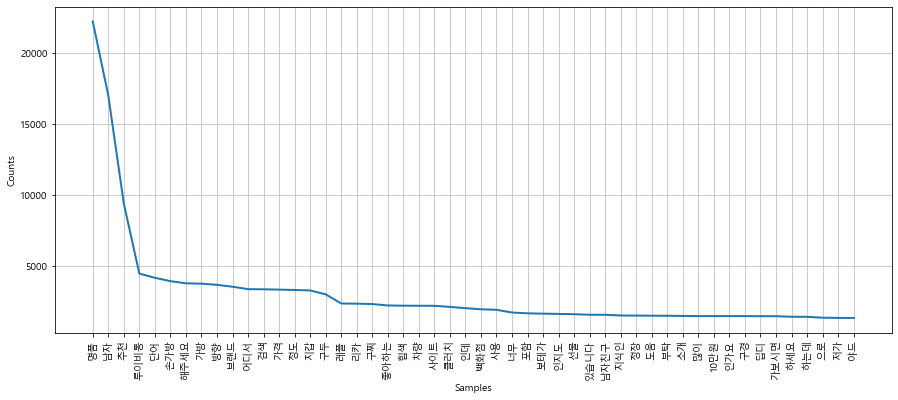

In [288]:
plt.figure(figsize=(15,6))
ko.plot(50)
plt.show()

In [289]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

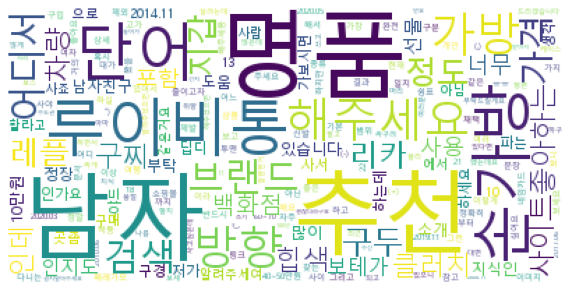

In [290]:
data = ko.vocab().most_common(300)
wordcloud = WordCloud(font_path='C:/Windows/Fonts/malgun.ttf',
                     relative_scaling = 0.1,
                     background_color = 'white').generate_from_frequencies(dict(data))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()